# Linear Regression Model for Player Selection

This notebook uses Ridge regression to recommend the best 4 players to field against a specific opponent team.

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Configuration
DATA_DIR = 'data/'
RANDOM_STATE = 42

In [2]:
# Load datasets
player_data = pd.read_csv(DATA_DIR + 'player_data.csv')
stint_data = pd.read_csv(DATA_DIR + 'stint_data.csv')

# Helper function to extract team from player name
def extract_team(player):
    return '_'.join(player.split('_')[:-1])

player_data['team'] = player_data['player'].apply(extract_team)

print(f"Loaded {len(stint_data)} stints and {len(player_data)} players")
print(f"Teams: {sorted(player_data['team'].unique())}")

Loaded 7448 stints and 144 players
Teams: ['Argentina', 'Brazil', 'Canada', 'Chile', 'Columbia', 'Denmark', 'France', 'Great.Britain', 'Japan', 'Poland', 'Sweden', 'USA']


## 2. Feature Engineering

Expand stint data to player-level records with opponent context.

In [3]:
def create_player_stint_records(stint_data):
    """
    Expand stint data to player-level records.
    Each record represents one player's performance in one stint against a specific opponent.
    """
    records = []
    
    for _, row in stint_data.iterrows():
        game_id = row['game_id']
        h_team = row['h_team']
        a_team = row['a_team']
        minutes = row['minutes']
        h_goals = row['h_goals']
        a_goals = row['a_goals']
        
        # Home players - opponent is a_team
        for i in range(1, 5):
            player = row[f'home{i}']
            records.append({
                'game_id': game_id,
                'player': player,
                'team': h_team,
                'opponent': a_team,
                'is_home': 1,
                'minutes': minutes,
                'goals_for': h_goals,
                'goals_against': a_goals,
                'goal_margin': h_goals - a_goals,
                'plus_minus_per_min': (h_goals - a_goals) / minutes if minutes > 0 else 0
            })
        
        # Away players - opponent is h_team
        for i in range(1, 5):
            player = row[f'away{i}']
            records.append({
                'game_id': game_id,
                'player': player,
                'team': a_team,
                'opponent': h_team,
                'is_home': 0,
                'minutes': minutes,
                'goals_for': a_goals,
                'goals_against': h_goals,
                'goal_margin': a_goals - h_goals,
                'plus_minus_per_min': (a_goals - h_goals) / minutes if minutes > 0 else 0
            })
    
    return pd.DataFrame(records)

player_stint_df = create_player_stint_records(stint_data)
print(f"Created {len(player_stint_df)} player-stint records")
player_stint_df.head()

Created 59584 player-stint records


,game_id,player,team,opponent,is_home,minutes,goals_for,goals_against,goal_margin,plus_minus_per_min
0,1,USA_p4,USA,Japan,1,4.252969,4,9,-5,-1.175649
1,1,USA_p1,USA,Japan,1,4.252969,4,9,-5,-1.175649
2,1,USA_p3,USA,Japan,1,4.252969,4,9,-5,-1.175649
3,1,USA_p6,USA,Japan,1,4.252969,4,9,-5,-1.175649
4,1,Japan_p12,Japan,USA,0,4.252969,9,4,5,1.175649


In [4]:
# Aggregate player-opponent statistics
player_opponent_stats = player_stint_df.groupby(['player', 'team', 'opponent']).agg({
    'minutes': 'sum',
    'goals_for': 'sum',
    'goals_against': 'sum',
    'goal_margin': 'sum',
    'game_id': 'nunique',
    'plus_minus_per_min': 'mean'
}).reset_index()

player_opponent_stats.rename(columns={'game_id': 'n_games'}, inplace=True)
player_opponent_stats['total_plus_minus_per_min'] = (
    (player_opponent_stats['goals_for'] - player_opponent_stats['goals_against']) / 
    player_opponent_stats['minutes']
)

print(f"Player-opponent combinations: {len(player_opponent_stats)}")
player_opponent_stats.head(10)

Player-opponent combinations: 1584


,player,team,opponent,minutes,goals_for,goals_against,goal_margin,n_games,plus_minus_per_min,total_plus_minus_per_min
0,Argentina_p1,Argentina,Brazil,106.347893,133,192,-59,9,-0.252341,-0.554783
1,Argentina_p1,Argentina,Canada,94.897187,137,168,-31,10,-0.168628,-0.326669
2,Argentina_p1,Argentina,Chile,91.217908,130,154,-24,10,-0.381065,-0.263106
3,Argentina_p1,Argentina,Columbia,119.051756,116,187,-71,9,-0.652849,-0.596379
4,Argentina_p1,Argentina,Denmark,67.573800,73,150,-77,10,-1.301532,-1.139495
5,Argentina_p1,Argentina,France,91.737032,89,173,-84,10,-1.023584,-0.915661
6,Argentina_p1,Argentina,Great.Britain,96.115399,107,158,-51,10,-0.774954,-0.530612
7,Argentina_p1,Argentina,Japan,103.239116,89,173,-84,10,-0.975718,-0.813645
8,Argentina_p1,Argentina,Poland,114.223037,121,192,-71,10,-0.627539,-0.621591
9,Argentina_p1,Argentina,Sweden,110.038550,163,167,-4,10,0.060119,-0.036351


## 3. Create Training Data with Player-Opponent Interactions

In [5]:
def create_interaction_features(stint_data):
    """
    Create player-opponent interaction features for regression.
    Feature format: player_X_vs_opponent_Y = 1 if player X is playing against team Y
    """
    records = []
    
    for _, row in stint_data.iterrows():
        minutes = row['minutes']
        
        # Home team perspective
        home_record = {
            'target': (row['h_goals'] - row['a_goals']) / minutes if minutes > 0 else 0,
            'minutes': minutes,
            'is_home': 1
        }
        
        home_players = [row[f'home{i}'] for i in range(1, 5)]
        opponent = row['a_team']
        
        for player in home_players:
            interaction_key = f'{player}_vs_{opponent}'
            home_record[interaction_key] = 1
        
        records.append(home_record)
        
        # Away team perspective
        away_record = {
            'target': (row['a_goals'] - row['h_goals']) / minutes if minutes > 0 else 0,
            'minutes': minutes,
            'is_home': 0
        }
        
        away_players = [row[f'away{i}'] for i in range(1, 5)]
        opponent = row['h_team']
        
        for player in away_players:
            interaction_key = f'{player}_vs_{opponent}'
            away_record[interaction_key] = 1
        
        records.append(away_record)
    
    df = pd.DataFrame(records).fillna(0)
    return df

interaction_df = create_interaction_features(stint_data)
print(f"Training data shape: {interaction_df.shape}")
print(f"Number of features: {len(interaction_df.columns) - 3}")

Training data shape: (14896, 1587)
Number of features: 1584


## 4. Train Ridge Regression Model

In [6]:
# Prepare features and target
feature_cols = [c for c in interaction_df.columns if c not in ['target', 'minutes']]

X = interaction_df[feature_cols]
y = interaction_df['target']
weights = interaction_df['minutes']

# Train/test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 11916
Test samples: 2980


In [7]:
# Train Ridge regression model
model = Ridge(alpha=10.0, random_state=RANDOM_STATE)
model.fit(X_train, y_train, sample_weight=w_train)

# Evaluate on test set
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred, sample_weight=w_test))
r2 = r2_score(y_test, y_pred, sample_weight=w_test)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2: {r2:.4f}")

Test RMSE: 1.3127
Test R2: 0.0789


## 5. Extract Player Coefficients

In [8]:
def extract_player_coefficients(model, feature_cols):
    """
    Extract player-opponent coefficients from the trained model.
    """
    coef_records = []
    
    for feat, coef in zip(feature_cols, model.coef_):
        if '_vs_' in feat:
            parts = feat.split('_vs_')
            player = parts[0]
            opponent = parts[1]
            coef_records.append({
                'player': player,
                'opponent': opponent,
                'coefficient': coef
            })
    
    return pd.DataFrame(coef_records)

player_coefficients = extract_player_coefficients(model, feature_cols)
print(f"Extracted {len(player_coefficients)} player-opponent coefficients")

# Show top coefficients
print("\nTop 10 player-opponent matchups:")
player_coefficients.nlargest(10, 'coefficient')

Extracted 1584 player-opponent coefficients

Top 10 player-opponent matchups:


,player,opponent,coefficient
1577,Denmark_p8,Chile,0.936229
1413,Brazil_p1,Chile,0.845133
211,USA_p8,Poland,0.795137
1177,Denmark_p6,Argentina,0.751489
781,Canada_p11,Sweden,0.735644
934,France_p10,Sweden,0.730123
561,Denmark_p8,Great.Britain,0.723639
381,Japan_p1,Brazil,0.700721
347,Japan_p12,Denmark,0.678626
780,Sweden_p4,Canada,0.675700


## 6. Recommendation Function

In [9]:
def get_best_lineup(team, opponent, model, feature_cols, player_data, top_n=4):
    """
    Recommend the best N players from a team to field against a specific opponent.
    
    Parameters:
    -----------
    team : str
        The team to select players from (e.g., 'USA')
    opponent : str
        The opponent team (e.g., 'Japan')
    model : Ridge
        Trained regression model
    feature_cols : list
        List of feature column names
    player_data : DataFrame
        Player information including ratings
    top_n : int
        Number of players to recommend (default 4)
    
    Returns:
    --------
    DataFrame with recommended players and their expected contributions
    """
    print(f"\n{'='*50}")
    print(f"LINEUP RECOMMENDATION: {team} vs {opponent}")
    print(f"{'='*50}\n")
    
    # Find all features for this team vs opponent
    pattern = f'_vs_{opponent}'
    relevant_features = [f for f in feature_cols if pattern in f]
    
    # Filter to players from the specified team
    team_player_features = [f for f in relevant_features 
                            if extract_team(f.split('_vs_')[0]) == team]
    
    if len(team_player_features) == 0:
        print(f"No historical data for {team} vs {opponent}")
        return None
    
    # Get coefficients for each player
    player_scores = []
    for feat in team_player_features:
        player = feat.split('_vs_')[0]
        feat_idx = feature_cols.index(feat)
        coef = model.coef_[feat_idx]
        
        rating = player_data[player_data['player'] == player]['rating'].values
        rating = rating[0] if len(rating) > 0 else 0
        
        player_scores.append({
            'player': player,
            'expected_contribution': coef,
            'rating': rating
        })
    
    scores_df = pd.DataFrame(player_scores)
    scores_df = scores_df.sort_values('expected_contribution', ascending=False)
    
    recommended = scores_df.head(top_n)
    
    print("Recommended Starting 4:")
    print("-" * 40)
    for i, row in enumerate(recommended.itertuples(), 1):
        print(f"  {i}. {row.player:20s} | Coef: {row.expected_contribution:+.4f} | Rating: {row.rating}")
    
    total_coef = recommended['expected_contribution'].sum()
    print("-" * 40)
    print(f"  Combined expected margin: {total_coef:+.4f} goals/min")
    
    return recommended

In [10]:
# Example recommendations
usa_vs_japan = get_best_lineup('USA', 'Japan', model, feature_cols, player_data)


LINEUP RECOMMENDATION: USA vs Japan

Recommended Starting 4:
----------------------------------------
  1. USA_p8               | Coef: +0.3860 | Rating: 2.5
  2. USA_p7               | Coef: +0.2492 | Rating: 1.5
  3. USA_p1               | Coef: +0.2449 | Rating: 3.0
  4. USA_p9               | Coef: +0.1523 | Rating: 1.0
----------------------------------------
  Combined expected margin: +1.0324 goals/min


In [11]:
usa_vs_sweden = get_best_lineup('USA', 'Sweden', model, feature_cols, player_data)


LINEUP RECOMMENDATION: USA vs Sweden

Recommended Starting 4:
----------------------------------------
  1. USA_p7               | Coef: +0.6400 | Rating: 1.5
  2. USA_p6               | Coef: +0.5746 | Rating: 0.5
  3. USA_p9               | Coef: +0.5175 | Rating: 1.0
  4. USA_p3               | Coef: +0.4896 | Rating: 3.5
----------------------------------------
  Combined expected margin: +2.2216 goals/min


In [12]:
japan_vs_usa = get_best_lineup('Japan', 'USA', model, feature_cols, player_data)


LINEUP RECOMMENDATION: Japan vs USA

Recommended Starting 4:
----------------------------------------
  1. Japan_p12            | Coef: +0.5025 | Rating: 2.5
  2. Japan_p7             | Coef: +0.4141 | Rating: 2.0
  3. Japan_p8             | Coef: +0.3561 | Rating: 1.5
  4. Japan_p1             | Coef: +0.2393 | Rating: 1.0
----------------------------------------
  Combined expected margin: +1.5121 goals/min


## 7. Evaluation

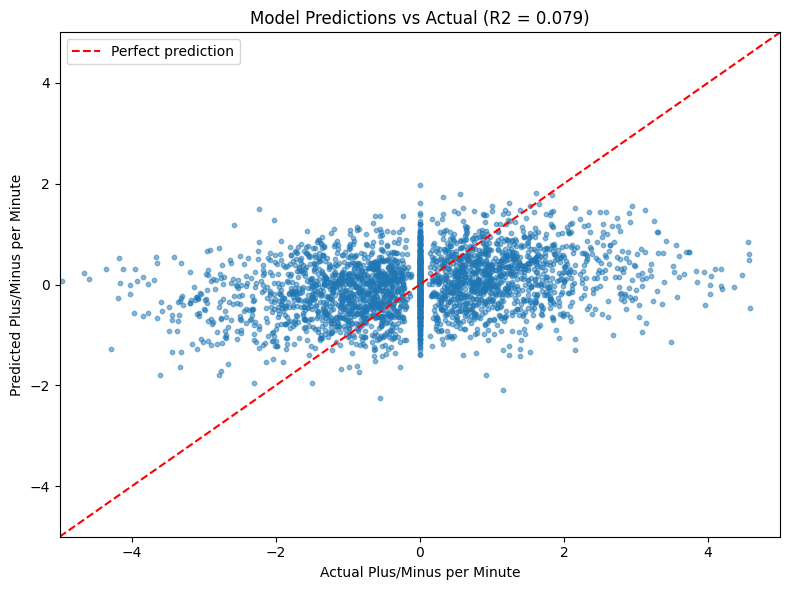

In [13]:
# Actual vs Predicted scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=10)
plt.plot([-5, 5], [-5, 5], 'r--', label='Perfect prediction')
plt.xlabel('Actual Plus/Minus per Minute')
plt.ylabel('Predicted Plus/Minus per Minute')
plt.title(f'Model Predictions vs Actual (R2 = {r2:.3f})')
plt.legend()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

## 8. Visualization - Player Effectiveness Heatmap

In [14]:
def plot_player_opponent_heatmap(player_coefficients, team):
    """
    Create a heatmap showing player effectiveness against each opponent.
    """
    # Filter to specified team
    team_coefs = player_coefficients[
        player_coefficients['player'].apply(extract_team) == team
    ].copy()
    
    if len(team_coefs) == 0:
        print(f"No data for team {team}")
        return None
    
    # Pivot for heatmap
    pivot_df = team_coefs.pivot(
        index='player', 
        columns='opponent', 
        values='coefficient'
    )
    
    plt.figure(figsize=(12, 8))
    im = plt.imshow(pivot_df.values, cmap='RdYlGn', aspect='auto', vmin=-0.5, vmax=0.5)
    plt.colorbar(im, label='Expected Contribution (goals/min)')
    
    plt.xticks(range(len(pivot_df.columns)), pivot_df.columns, rotation=45, ha='right')
    plt.yticks(range(len(pivot_df.index)), pivot_df.index)
    
    plt.xlabel('Opponent')
    plt.ylabel('Player')
    plt.title(f'{team} Player Effectiveness by Opponent')
    plt.tight_layout()
    plt.show()
    
    return pivot_df

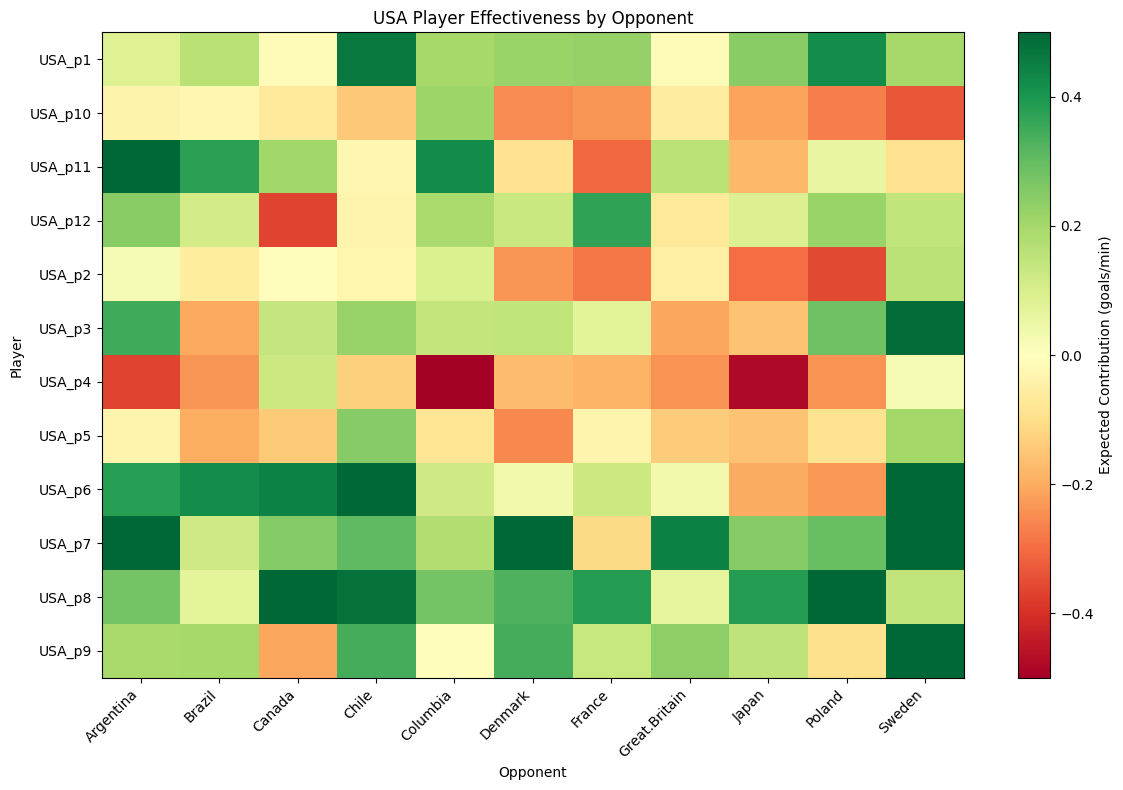

In [15]:
# Heatmap for USA players
usa_effectiveness = plot_player_opponent_heatmap(player_coefficients, 'USA')

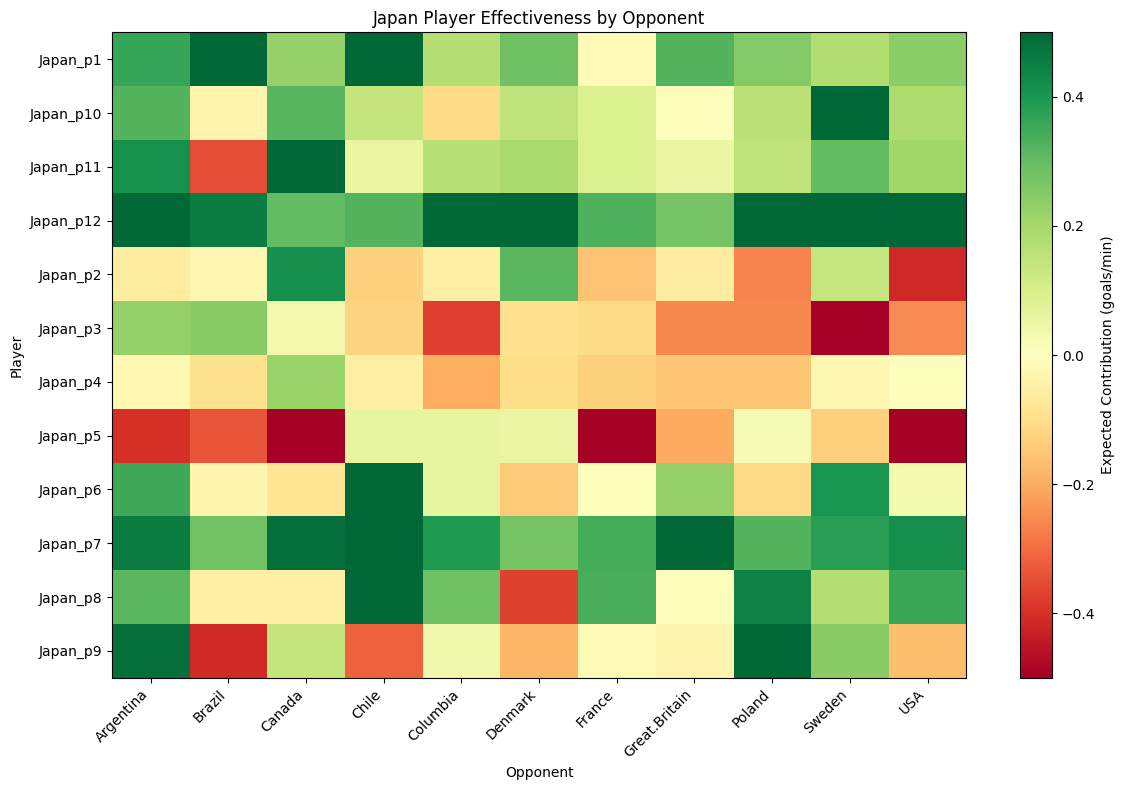

In [16]:
# Heatmap for Japan players
japan_effectiveness = plot_player_opponent_heatmap(player_coefficients, 'Japan')

## 9. Summary

In [17]:
# Calculate correlation between ratings and model coefficients
avg_coefs = player_coefficients.groupby('player')['coefficient'].mean().reset_index()
merged = player_data.merge(avg_coefs, on='player')
rating_coef_corr = merged['rating'].corr(merged['coefficient'])

print("="*60)
print("REGRESSION MODEL SUMMARY")
print("="*60)
print(f"""
Model Approach:
- Ridge regression with player-opponent interaction features
- Target variable: plus_minus_per_min (goal margin normalized by time)
- Regularization alpha: 10.0

Performance:
- Test RMSE: {rmse:.4f}
- Test R2: {r2:.4f}

Key Findings:
- Correlation between player ratings and model coefficients: {rating_coef_corr:.3f}
- Number of player-opponent features: {len(player_coefficients)}

Usage:
- Call get_best_lineup(team, opponent, model, feature_cols, player_data)
- Returns top 4 players with highest expected contribution

Limitations:
- Assumes player interactions are additive (no synergy modeling)
- Based on historical data only
""")

REGRESSION MODEL SUMMARY

Model Approach:
- Ridge regression with player-opponent interaction features
- Target variable: plus_minus_per_min (goal margin normalized by time)
- Regularization alpha: 10.0

Performance:
- Test RMSE: 1.3127
- Test R2: 0.0789

Key Findings:
- Correlation between player ratings and model coefficients: 0.272
- Number of player-opponent features: 1584

Usage:
- Call get_best_lineup(team, opponent, model, feature_cols, player_data)
- Returns top 4 players with highest expected contribution

Limitations:
- Assumes player interactions are additive (no synergy modeling)
- Based on historical data only

